- Final Social > Unsure > Non-social analyses and results 
Original name of this notebook: 2_5_fMRI_allmovies_S_v_unsure_v_NS_figsforpaper.ipynb (renaming to reduce clutter)

Rekha Varrier, 2021-22

In [5]:
# import general packages, check folders
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from pathlib import Path

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [6]:
# setting default fontsizes for plots
s=20 # CHANGE FONTSIZE HERE
plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend

In [7]:
#suff= ''
suff = '_corrected'

In [8]:
# load behavioral data - coded 1 for "social", 0 for "nonsocial" and 9 for "unsure", nan for missed response
responses = np.load(os.path.join(data_file_loc,f'responses{suff}.npy'))
responses.shape # subs *movies

(1049, 10)

In [9]:
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vidnames # all movie names

['COAXING-B',
 'BILLIARD-A',
 'DRIFTING-A',
 'Fishing',
 'Random mechanical',
 'Scaring',
 'SEDUCING-B',
 'STAR-A',
 'SURPRISING-B',
 'TENNIS-A']

In [10]:
# importing packages for multiple comparison correction
from mne.stats import fdr_correction
from multipy.fdr import lsu
#from multipy.data import neuhaus

# ALL MOVIES    

In [11]:
sub_id_all = np.load(os.path.join(data_file_loc,f'sub_id_all{suff}.npy'))
sub_id_all.shape# get subject IDs as assigned in HCP

(1049,)

In [12]:
# first of all, best to remove subjects with < 10 responses for power in general
count_resp = np.zeros((responses.shape[0],))
for i in range(responses.shape[0]):
    count_resp[i] = len(np.where(~np.isnan(responses[i,:]))[0])
subs_10resp = np.where(count_resp == 10)[0]
len(subs_10resp)

#install lme and time-tracking functions
from pymer4.models import Lmer
import time
from datetime import datetime

In [14]:
# creating a 3D array of beta coeffs across movies from individual movie files
all_coefs = np.zeros((responses.shape[0],268,10))
for m in range(10):
    fileName =  os.path.join(data_file_loc,'coefs_run_norm','slope_reg',f'coef_slopereg_runnorm_{vidnames[m]}{suff}.npy')
    all_coefs[:,:,m] = np.load(fileName)

In [24]:
movie_rfx = 0 # 1: include subject and movie as rfx, 0: have only subject as
if movie_rfx == 1: # not used in Manuscript 
    lme_suff = '_movieRFX'
else:  # used in manuscript
    lme_suff = ''

In [25]:
load_all = 1 # 1: load saved coefs, 0: run the LME

In [26]:
# "Social" v Unsure (ALL movies)

if load_all == 0: 
    coef_soc_uns_ALL, coef_uns_nonsoc_ALL= [np.empty((268,)) for _ in range(2)]
    coef_soc_uns_ALL[:], coef_uns_nonsoc_ALL[:] = [np.nan]*2
    pval_soc_uns_ALL, pval_uns_nonsoc_ALL = [np.empty((268,)) for _ in range(2)]
    pval_soc_uns_ALL[:], pval_uns_nonsoc_ALL[:] = [np.nan]*2

flname = f'lmecoefs_all_soc_v_unsure_ALLmovies{lme_suff}.npy'

if load_all == 1:    
    [coef_soc_uns_ALL,pval_soc_uns_ALL] = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg',flname), allow_pickle=True)
else:
    start_time =  time.time()
    for n in range(268): # all brain regions
        if n%10 == 0:
            print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
        
        df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
        for m in range(10): # all movies
            df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
            df = df.append(df_temp,ignore_index=True)
            df = df.loc[df['response'] != 0] # yes v unsure
        df['response'] = df['response'].map({1.0: "Social", 9.0:  "Unsure"})
        if movie_rfx == 0:
            model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
        else:
            model = Lmer('coefs ~  response +(1|subID) + (1|movie)', data=df) # ff: mean response, rf:subjID, movie
    
        model.fit(factors={"response":["Unsure","Social"]},summary = False, verbose = False)
        if n == 0:
            print('model:',model.fit(factors={"response":["Unsure","Social"]}))
        coef_soc_uns_ALL[n] = model.coefs['Estimate'][1]
        pval_soc_uns_ALL[n]= model.coefs['P-val'][1]
    np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg',flname), [coef_soc_uns_ALL,pval_soc_uns_ALL])
    print('Done on/at:',datetime.now()) # cell run at)

In [27]:
# "Unsure" vs. "Non-social"
flname = f'lmecoefs_all_unsure_v_nonsoc_ALLmovies{lme_suff}.npy'

if load_all == 1:
    [coef_uns_nonsoc_ALL,pval_uns_nonsoc_ALL] = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg',\
        flname), allow_pickle=True)
else:
    start_time =  time.time()
    for n in range(268): # all brain regions/parcels
        if n%10 == 0:
            print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
        df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
        
        for m in range(10): # all movies
            df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
            df = df.append(df_temp,ignore_index=True)
            df = df.loc[df['response'] != 1] # no v unsure
            
        df['response'] = df['response'].map({0.0: "Non-social", 9.0:  "Unsure"})
        if movie_rfx == 0:
            model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
        else:
            model = Lmer('coefs ~  response +(1|subID) + (1|movie)', data=df) # ff: mean response, rf:subjID, movie
    
        model.fit(factors={"response":["Non-social","Unsure"]},summary = False, verbose = False)
        if n == 0:
            print(model.fit(factors={"response":["Non-social","Unsure"]}))
        coef_uns_nonsoc_ALL[n] = model.coefs['Estimate'][1]
        pval_uns_nonsoc_ALL[n]= model.coefs['P-val'][1]
    np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg',flname),[coef_uns_nonsoc_ALL,pval_uns_nonsoc_ALL])
    print('Done on/at:',datetime.now()) # cell run at)

In [28]:
# for comparison with the other main figure if needed
nodes_coaxbill_rand_all = np.load(os.path.join(data_file_loc,'nodes_coaxbill_rand_all.npy')) # sig nodes hihglighted in the first S>NS GLM
len(np.where(nodes_coaxbill_rand_all)[0])

70

In [29]:
# FDR-correct s>unsure and unsure >ns
pval_soc_uns_corr_ALL = lsu(pval_soc_uns_ALL,q=.05) 
pval_uns_nonsoc_corr_ALL = lsu(pval_uns_nonsoc_ALL,q=.05) 
pval_soc_uns_unc_ALL  = pval_soc_uns_ALL <.05
pval_uns_nonsoc_unc_ALL  = pval_uns_nonsoc_ALL <.05

In [95]:
# to plot in revision 1
soc_uns_FDR_GLMnodes = pval_soc_uns_corr_ALL     & nodes_coaxbill_rand_all 
uns_ns_FDR_GLMnodes  = pval_uns_nonsoc_corr_ALL  & nodes_coaxbill_rand_all 
nodes_revision1 = {'soc_uns': soc_uns_FDR_GLMnodes, 'uns_ns': uns_ns_FDR_GLMnodes }

In [96]:
# ALL social>unsure and unsure>non-social or vice-versa
# uncorrected and within social proc regions
nodes_all_SUNS_UNSNS_unc_ALL = (pval_soc_uns_unc_ALL) & (pval_uns_nonsoc_unc_ALL) & \
(np.sign(coef_soc_uns_ALL) == np.sign(coef_uns_nonsoc_ALL)) & nodes_coaxbill_rand_all 

#corrected and within social proc regions
nodes_all_SUNS_UNSNS_ALL = (pval_soc_uns_corr_ALL) & (pval_uns_nonsoc_corr_ALL) & \
    (np.sign(coef_soc_uns_ALL) == np.sign(coef_uns_nonsoc_ALL))  & nodes_coaxbill_rand_all

print('all:', len(np.where(nodes_all_SUNS_UNSNS_unc_ALL)[0]), len(np.where(nodes_all_SUNS_UNSNS_ALL)[0]))


all: 38 35


# Plot

In [49]:
# get the right red/blue shades
#red_rgb = [103,0,31] # edges of RdBu
#blue_rgb = [5,48,97] # edges of RdBu
red_rgb =[188,61,62] # from Emily
blue_rgb = [54,122,177] # from Emily
red_rgb = np.array(red_rgb)/255
blue_rgb = np.array(blue_rgb)/255
alpha = .2 # transparency inside boxplots, for datapts etc.
shen268_lbl = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
shen268_lbl.head()
TR=.72


In [31]:
## Save ROIs

fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig4_soc_unsure_nonsoc_figs3,4/')


cols = ['k','k','g']
lw = [3,2,1]

lbl = [str.upper(x[0:4]) for x in vidnames]
lbl
#import plotting functions
from nilearn.surface import vol_to_surf
from nilearn.plotting import plot_glass_brain, plot_surf_roi,plot_stat_map,plot_img,plot_surf_contours
import nibabel as nib
from nilearn import datasets
bg_img = datasets.load_mni152_template()

from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()

from nilearn import datasets
bg_img = datasets.load_mni152_template()

from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

def color_rois(values):
    
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    shen268 = nib.load(os.path.join(data_file_loc,"shen_2mm_268_parcellation.nii.gz"))
    shen268_data = shen268.get_fdata()
    img = np.zeros(shen268_data.shape)
    for roi in range(len(values)):
        itemindex = np.where(shen268_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
        img[itemindex] = values[roi] # color them by the desired value 

    affine = shen268.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii

In [33]:
def surf_plot_all(fig, ax, nodes, params, movie_rfx, plot_v5=True):

    title_txt = params['title']
    txt  = params['txt']
    vmin = params['vmin']
    vmax = params['vmax']

    #LH (left hemisphere)
    ax_surf = ax[0,0] # left lateral (upper left subplot)
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left,axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    if movie_rfx:
        texture_contour = vol_to_surf(color_rois(nodes_all_SUNS_UNSNS_ALL), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_left, texture_contour, axes = ax_surf,figure=surf_plot1, legend=True,levels = [1], colors=['k'])

    ax_surf = ax[1,0] # left medial (lower left subplot)
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    if movie_rfx:
        plot_surf_contours(fsaverage.infl_left, texture_contour, axes = ax_surf,figure=surf_plot2, legend=True,levels = [1], colors=['k'])
    
    #RH (right hemisphere)
    ax_surf = ax[0,1] # upper right subplot
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right,axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    surf_plot3.axes[4].text(10,.5*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    if movie_rfx:
        texture_contour = vol_to_surf(color_rois(nodes_all_SUNS_UNSNS_ALL), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_right, texture_contour, axes = ax_surf,figure=surf_plot3, legend=True,levels = [1], colors=['k'])
    
    box = surf_plot3.axes[4].get_position()
    surf_plot3.axes[4].set_position([box.x0*.93, box.y0-.3, box.width, box.height*2])  # move a bit the bar to the right, need to divide by number of columns (to move relative to last figure only, not to overall row, else will get too far away)
    
    ax_surf = ax[1,1] # lower right subplot
    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right, view ='medial',axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    
    if movie_rfx:
        plot_surf_contours(fsaverage.infl_right, texture_contour, axes = ax_surf,figure=surf_plot4, legend=True, levels = [1], colors=['k'])#, labels=['Sig. (q<.05) across\n(a),(c),(d)'])
    
    if plot_v5: # in case we want to highlight region V5
        v5_texture = vol_to_surf(v5_roi_nii, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
        thr99 = np.quantile(v5_texture,.99)
        v5_texture[v5_texture<thr99] = 0
        v5_texture[v5_texture!=0] = 1
        plot_surf_contours(fsaverage.infl_left,  v5_texture, figure=surf_plot1, legend=False, axes=ax[0,0],levels=[1],colors=['g'])#,levels = [texture],  labels=['Fig 3 nodes'])
        
        v5_texture = vol_to_surf(v5_roi_nii, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
        thr99 = np.quantile(v5_texture,.99)
        v5_texture[v5_texture<thr99] = 0
        v5_texture[v5_texture!=0] = 1
        plot_surf_contours(fsaverage.infl_right, v5_texture, figure=surf_plot3, legend=False, axes=ax[0,1],levels=[1],colors=['g'])#,levels = [texture],  labels=['Fig 3 nodes'])


    ax[0,0].dist = 7 # change viewing distance to "zoom in" to surface plots
    ax[0,1].dist = 7
    ax[1,0].dist = 7
    ax[1,1].dist = 7

    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=.8, 
                        top=1, 
                        wspace=0.0, 
                        hspace=-.1)


In [34]:
print('all:', len(np.where(nodes_all_SUNS_UNSNS_unc_ALL)[0]), len(np.where(nodes_all_SUNS_UNSNS_ALL)[0])) # uncorrected and corrected nodes

all: 38 35


In [35]:
# region V5 (not plotting this in the final results, but useful to understand how much V5 showed social evidence accumulation)
v5_roi = 'v5_association-test_z_FDR_0.01.nii'
v5_roi_loc = f'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/ROIs/{v5_roi}'
v5_roi_nii = nib.load(v5_roi_loc)

In [36]:
fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig4_soc_unsure_nonsoc_figs3,4/')
comp_lbls = ['Soc_Unsure','Unsure_Nonsoc']

In [38]:
if movie_rfx:
    print('sub and movie rfx')
    print(min(coef_soc_uns_ALL[nodes_all_SUNS_UNSNS_unc_ALL]), max(coef_soc_uns_ALL[nodes_all_SUNS_UNSNS_unc_ALL] ))
else:
    print('sub only rfx')
    print(min(coef_soc_uns_ALL[nodes_all_SUNS_UNSNS_ALL]), max(coef_soc_uns_ALL[nodes_all_SUNS_UNSNS_ALL]) )

sub only rfx
0.08061603703582024 0.5375388671613495


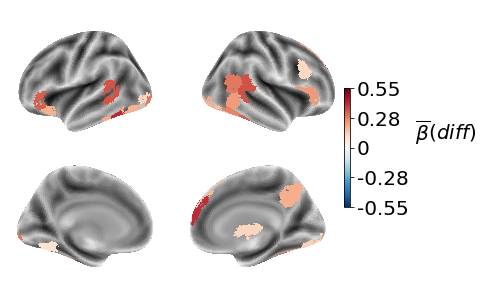

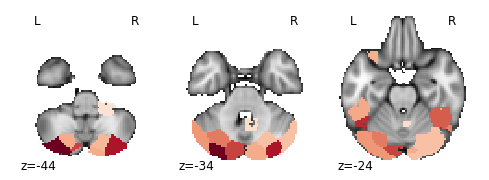

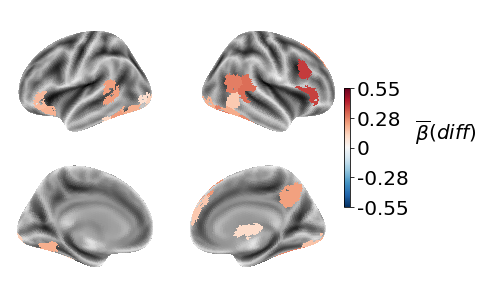

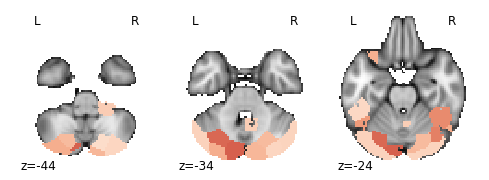

In [39]:
# surface plots
if movie_rfx:
    vmin,vmax = -.24,.24
else:
    vmin,vmax = -.55,.55
    
cmap = 'RdBu_r'
title_txt = 'ALL'

for comp in range(2): # "Social" > "Unsure" and "Unsure" > "Non-social"
    nodes = np.zeros((268,))
    if comp == 0:    
        txt = '  'r"$\overline{\beta}{(diff)}$"
        if movie_rfx:
            nodes[nodes_all_SUNS_UNSNS_unc_ALL] = coef_soc_uns_ALL[nodes_all_SUNS_UNSNS_unc_ALL] 
        else:
            nodes[nodes_all_SUNS_UNSNS_ALL] = coef_soc_uns_ALL[nodes_all_SUNS_UNSNS_ALL] 
        
    else:
        txt = '  'r"$\overline{\beta}{(diff)}$"
        if movie_rfx:
            nodes[nodes_all_SUNS_UNSNS_unc_ALL] = coef_uns_nonsoc_ALL[nodes_all_SUNS_UNSNS_unc_ALL]# nodes to be colored - those that show a social > unsure > NS for all movies (across rand and all othrs will be contoured)
        else:
            nodes[nodes_all_SUNS_UNSNS_ALL] = coef_uns_nonsoc_ALL[nodes_all_SUNS_UNSNS_ALL]
    
    fig,ax = plt.subplots(nrows=2, ncols= 2,figsize=(6,4),subplot_kw={'projection': '3d'})
    params = {'title':title_txt,'txt':txt, 'vmin': vmin, 'vmax':vmax}
    plot_V5 = False # change here to remove V5 contours
    surf_plot_all(fig,ax,nodes, params, movie_rfx, plot_V5)
    v5_flname_suff = 'withV5' if plot_V5==True else ''
    plt.savefig(os.path.join(fig_save_loc,f'ALL_MOVIES/surf_all4_{comp_lbls[comp]}_{v5_flname_suff}{lme_suff}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
        
    img = roi_to_brain(pd.Series(nodes), mask_x)
    coords = [-44,-34,-24] # initial exploration
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)
    if movie_rfx:
        ax_plot.add_contours(color_rois(nodes_all_SUNS_UNSNS_ALL),linewidths=1, colors=['k'],linestyles ='-',filled=False)

    plt.savefig(os.path.join(fig_save_loc,f'ALL_MOVIES/{comp_lbls[comp]}_axial{lme_suff}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

# Revision 1 plots (accepted manuscript; Figure 5)

- Main difference from the figure above:
1. the colored regions aren't filtered for the intersection of S > Uns and Uns > NS analyses - ie., the 2 plots in the figures below can look different
2. black contours are used to highlight this difference

- Both earlier and this version:
1. the colored regions are filtered to be within the social processing regions
2. have separate figures for S > Uns and Uns > NS across all animations


In [140]:

def surf_plot_all_rev1(fig, ax_list, nodes, params, plot_contours, row_wise, view_dist = 7):

    title_txt = params['title']
    txt  = params['txt']
    vmin = params['vmin']
    vmax = params['vmax']

    #LH
    ax_surf = ax_list[0] #ax[0,0] # left lateral (upper left)
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left,axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    
    if plot_contours:
        texture_contour = vol_to_surf(color_rois(nodes_all_SUNS_UNSNS_ALL), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_left, texture_contour, axes = ax_surf,figure=surf_plot1, legend=True,levels = [1], colors=['k'])

    ax_surf = ax_list[1] #ax[1,0] # left medial (lower left)
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    
    if plot_contours:
        plot_surf_contours(fsaverage.infl_left, texture_contour, axes = ax_surf,figure=surf_plot2, legend=True,levels = [1], colors=['k'])
    
    #RH
    ax_surf = ax_list[2] #ax[0,1] # upper right
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right,axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    
    if ~row_wise:
        surf_plot3.axes[4].text(10,.5*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    
    if plot_contours:
        texture_contour = vol_to_surf(color_rois(nodes_all_SUNS_UNSNS_ALL), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_right, texture_contour, axes = ax_surf,figure=surf_plot3, legend=True,levels = [1], colors=['k'])
    
    box = surf_plot3.axes[4].get_position()
    surf_plot3.axes[4].set_position([box.x0*.93, box.y0-.3, box.width, box.height*2])  # move a bit the bar to the right, need to divide by number of columns (to move relative to last figure only, not to overall row, else will get too far away)
    
    ax_surf = ax_list[3] #ax[1,1] # lower right
    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right, view ='medial',axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    if row_wise:
        surf_plot3.axes[4].text(10,.5*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    

    if plot_contours:
        plot_surf_contours(fsaverage.infl_right, texture_contour, axes = ax_surf,figure=surf_plot4, legend=True, levels = [1], colors=['k'])#, labels=['Sig. (q<.05) across\n(a),(c),(d)'])

    if row_wise == 0:
        ax[0,0].dist = view_dist # change viewing distance to "zoom in" to surface plots
        ax[0,1].dist = view_dist
        ax[1,0].dist = view_dist
        ax[1,1].dist = view_dist
    else:
        for i in range(4):
            ax_list[i].dist = view_dist # change viewing distance to "zoom in" to surface plots


    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=.8, 
                        top=1, 
                        wspace=0.0, 
                        hspace=-.1)
   

In [130]:
intersection_nodes = nodes_revision1['soc_uns'] & nodes_revision1['uns_ns']
same_sign_regions = np.sign(coef_soc_uns_ALL) == np.sign(coef_uns_nonsoc_ALL)
#intersection_nodes_same_sign = intersection_nodes & same_sign_regions
# intersection_nodes_same_sign is the same as nodes_all_SUNS_UNSNS_ALL, so leaving it 
len(np.where(nodes_revision1['soc_uns'])[0]), len(np.where(nodes_revision1['uns_ns'])[0])#len(np.where(intersection_nodes)[0]), len(np.where(intersection_nodes_same_sign)[0]) 

(51, 60, 43, 35)

In [112]:
min(coef_soc_uns_ALL), max(coef_soc_uns_ALL)

(-0.3761706521413878, 0.742538017677643)

## (a-b) Soc v Uns and Uns v Non-soc


- Note that here, the colors = nodes showing S > Uns or Uns > NS within the social processing regions (black  contours in other figures). In this figure, black contours refer to the intersection of the results (i.e., regions showing this difference significantly) between S > Uns  and Uns > NS


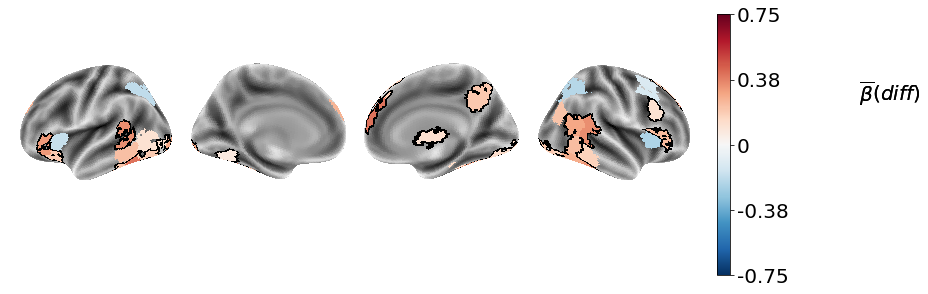

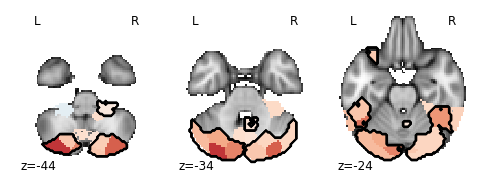

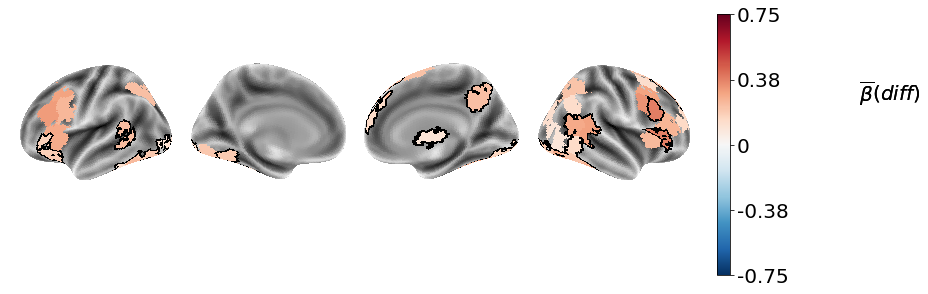

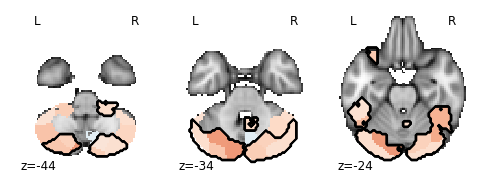

In [125]:
# revision 1, nodes intersecting not sub-selected
vmin,vmax = -.75,.75
cmap = 'RdBu_r'
#txt = r' $\overline{\beta}(\""")-$' + '\n' + r'$\overline{\beta}_{Non-social}$'+ '\n'
title_txt = 'ALL'
row_wise = 1 # 1 if one row, 4 cols, 0 if 2x2
plot_contours = 1
for comp in range(2): # S > Uns or Uns > NS
    nodes = np.zeros((268,))
    if comp == 0:    
        txt = '  'r"$\overline{\beta}{(diff)}$"
        if movie_rfx:
            print('change movie_rfx val')
        else:
            nodes[nodes_revision1['soc_uns']] = coef_soc_uns_ALL[nodes_revision1['soc_uns']] 
    else:
        txt = '  'r"$\overline{\beta}{(diff)}$"
        if movie_rfx:
            print('change movie_rfx val')
        else:
            nodes[nodes_revision1['uns_ns']] = coef_uns_nonsoc_ALL[nodes_revision1['uns_ns']] 
            
    fig,axs = plt.subplots(nrows=1, ncols= 4,figsize=(12,4),subplot_kw={'projection': '3d'})
    ax_list = [axs[0],axs[1],axs[3],axs[2]]
    params = {'title':title_txt,'txt':txt, 'vmin': vmin, 'vmax':vmax}
    surf_plot_all_rev1(fig,ax_list,nodes, params, plot_contours, row_wise)
    plt.savefig(os.path.join(fig_save_loc,f'ALL_MOVIES/surf_all4_{comp_lbls[comp]}_{v5_flname_suff}{lme_suff}_revision1_a_row.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

    img = roi_to_brain(pd.Series(nodes), mask_x)
    coords = [-44,-34,-24] # initial exploration
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)
    if plot_contours:
        ax_plot.add_contours(color_rois(nodes_all_SUNS_UNSNS_ALL),linewidths=1, colors=['k'],linestyles ='-',filled=False)

    plt.savefig(os.path.join(fig_save_loc,f'ALL_MOVIES/{comp_lbls[comp]}_axial{lme_suff}_revision1_a.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

## (c) Plot a flat map of the intersecting nodes

- This figure shows all intersecting regions: S > Uns > NS or vice-versa in the same color - goal being to highlight the regions showing parametric evidence accumulation

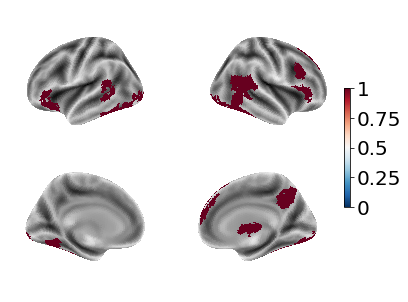

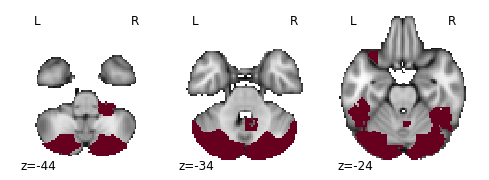

In [142]:
#intersection
# revision 1, nodes not sub-selected
vmin,vmax = 0,1
cmap = 'RdBu_r'
title_txt = ''

row_wise = 0
plot_contours = 0
nodes = np.zeros((268,))

txt = ''
if movie_rfx:
    print('change movie_rfx val')
else:
    nodes[nodes_all_SUNS_UNSNS_ALL] = 1

fig,axs = plt.subplots(nrows=2, ncols= 2,figsize=(6,4),subplot_kw={'projection': '3d'})
params = {'title':title_txt,'txt':txt, 'vmin': vmin, 'vmax':vmax}
ax_list = [axs[0,0],axs[1,0],axs[0,1],axs[1,1]]
view_dist = 3
surf_plot_all_rev1(fig,ax_list,nodes, params, plot_contours,row_wise, view_dist)
plt.savefig(os.path.join(fig_save_loc,f'ALL_MOVIES/surf_all4_flatcolormap_revision1_a.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    
img = roi_to_brain(pd.Series(nodes), mask_x)
coords = [-44,-34,-24] # initial exploration
ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)
if plot_contours:
    ax_plot.add_contours(color_rois(nodes_all_SUNS_UNSNS_ALL),linewidths=1, colors=['k'],linestyles ='-',filled=False)

plt.savefig(os.path.join(fig_save_loc,f'ALL_MOVIES/axial_flatcolormap_revision1_a.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

## Timecourse plots (Figure 5d); random mech

- To visualize evidence accumulation in terms of activity time courses, we plot timecourses for the most ambiguous movie (random mech)

In [40]:
movie_ind = 4
coef_slope_rand = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg',f'coef_slopereg_runnorm_Random mechanical{suff}.npy'))

soc_inds = (responses[:,movie_ind]==1) #& (allresp == 1) # subs who responded "social"
nonsoc_inds = (responses[:,movie_ind]==0)  #& (allresp == 1) # subs who respoded "nonsocial"
unsure_inds = (responses[:,movie_ind]==9) #& (allresp == 1) # subs who respoded "unsure"

print(f'movie={vidnames[movie_ind]},soc={len(np.where(soc_inds)[0])},nonsocial={len(np.where(nonsoc_inds)[0])},unsure={len(np.where(unsure_inds)[0])}')

# ttest between slope regs yes vs. no
_,pval_slope_rand_S_NS = stats.ttest_ind(coef_slope_rand[soc_inds,:], coef_slope_rand[nonsoc_inds,:],axis=0, equal_var=False)
pval_slope_rand_S_NS = lsu(pval_slope_rand_S_NS,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_S_NS = np.nanmean(coef_slope_rand[soc_inds,:],axis=0)-np.nanmean(coef_slope_rand[nonsoc_inds,:],axis=0)

# ttest between slope regs yes vs. unsure
_,pval_slope_rand_S_UNS_unc = stats.ttest_ind(coef_slope_rand[soc_inds,:], coef_slope_rand[unsure_inds,:],axis=0, equal_var=False)
pval_slope_rand_S_UNS = lsu(pval_slope_rand_S_UNS_unc,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_S_UNS = np.nanmean(coef_slope_rand[soc_inds,:],axis=0)-np.nanmean(coef_slope_rand[unsure_inds,:],axis=0)

# ttest between slope regs unsure vs. no
_,pval_slope_rand_UNS_NS_unc = stats.ttest_ind(coef_slope_rand[unsure_inds,:], coef_slope_rand[nonsoc_inds,:],axis=0, equal_var=False)
pval_slope_rand_UNS_NS = lsu(pval_slope_rand_UNS_NS_unc,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_UNS_NS = np.nanmean(coef_slope_rand[unsure_inds,:],axis=0)-np.nanmean(coef_slope_rand[nonsoc_inds,:],axis=0)

_,pval_slope_rand_S_UNS_unc1 = stats.ttest_ind(coef_slope_rand[soc_inds,:], coef_slope_rand[unsure_inds,:],axis=0, equal_var=False)
_,pval_slope_rand_UNS_NS_unc1 = stats.ttest_ind(coef_slope_rand[unsure_inds,:], coef_slope_rand[nonsoc_inds,:],axis=0, equal_var=False)

pval_slope_rand_UNS_NS_unc = pval_slope_rand_UNS_NS_unc<.05
pval_slope_rand_S_UNS_unc = pval_slope_rand_S_UNS_unc < .05

# social>unsure and unsure>non-social or vice-versa, both corrected
nodes_rand_SUNS_UNSNS = (pval_slope_rand_S_UNS) & (pval_slope_rand_UNS_NS) & (np.sign(meanDiff_sl_rand_S_UNS) == np.sign(meanDiff_sl_rand_UNS_NS)) 
print('nodes_rand_SUNS_UNSNS:',len(np.where(nodes_rand_SUNS_UNSNS)[0])) # no sig  ndoes for RAND

#### same as above, unc.
# social>unsure and unsure>non-social or vice-versa, both uncorrected
nodes_rand_SUNS_UNSNS_unc = (pval_slope_rand_S_UNS_unc) & (pval_slope_rand_UNS_NS_unc) & (np.sign(meanDiff_sl_rand_S_UNS) == np.sign(meanDiff_sl_rand_UNS_NS)) 
print('nodes_rand_SUNS_UNSNS_unc:',len(np.where(nodes_rand_SUNS_UNSNS_unc)[0])) # 5 sig nodes for RAND


movie=Random mechanical,soc=107,nonsocial=670,unsure=225
nodes_rand_SUNS_UNSNS: 0
nodes_rand_SUNS_UNSNS_unc: 5


In [41]:
common_nodes_soc_uns_nonsoc =  nodes_rand_SUNS_UNSNS_unc & nodes_all_SUNS_UNSNS_ALL
np.where(common_nodes_soc_uns_nonsoc) # no intersection regions (also not the best idea since all movies includes rand)

(array([], dtype=int64),)

- Let's try to sort the "ALL movies" n nodes by how close the beta_S_uns/bdeta_uns_NS ratio is to 1.

In [71]:
def remove_pretrial_TRs(tcs,vid_start_rel_tr,pretrial_TRs):
    tcs1 = np.empty((tcs.shape[0],tcs.shape[1],28+pretrial_TRs,tcs.shape[3]))
    tcs1[:] = np.nan
    for vid_no in range(10):
        tr0 = vid_start_rel_tr[vid_no]
        tcs1[:,:,:,vid_no] = tcs[:,:,tr0-pretrial_TRs:tr0+28,vid_no] # 31 timepts
    return tcs1

#select subs who responded "social" to the yes movie and nonsocial to the no movie
print('\nrun-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm{suff}.npy') # load fmri data
tcs_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_run_z.shape)
tcs_run_z = remove_pretrial_TRs(tcs_run_z,vid_start_rel_tr,tr0_ind)
print('after:',tcs_run_z.shape)


run-wise norm data.
before: (1049, 268, 56, 10)
after: (1049, 268, 31, 10)


In [72]:
# get a variable storing whether nodes show a difference in the end

soc_inds = (responses[:,movie_ind]==1) #& (allresp == 1) # subs who responded "social"
nonsoc_inds = (responses[:,movie_ind]==0)  #& (allresp == 1) # subs who respoded "nonsocial"
unsure_inds = (responses[:,movie_ind]==9) #& (allresp == 1) # subs who respoded "unsure"
pval_end_rand,    meandiff_end_rand, ntimepts_rand    = [np.empty((268,2)) for _ in range(3)]
pval_end_rand[:], meandiff_end_rand[:], ntimepts_rand[:] = [np.nan]*3
 
end_trs = 5
for n in range(268):# np.arange(10):
    tcn1 = np.nanmean(tcs_run_z[soc_inds,   n,-end_trs:,4],axis=1)# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    tcn2 = np.nanmean(tcs_run_z[unsure_inds,n,-end_trs:,4],axis=1)
    ntimepts_rand[n,0] =  np.sum(np.sign(np.nanmean(tcs_run_z[soc_inds,   n,-end_trs:,4],axis=0) - \
         np.nanmean(tcs_run_z[unsure_inds,   n,-end_trs:,4],axis=0)))
    
    _,pval_end_rand[n,0] = stats.ttest_ind(tcn1,tcn2,nan_policy='omit', equal_var= False)
    meandiff_end_rand[n,0] = np.nanmean(tcn1) - np.nanmean(tcn2)
    
    tcn1 = np.nanmean(tcs_run_z[unsure_inds, n,-end_trs:,4],axis=1)# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    tcn2 = np.nanmean(tcs_run_z[nonsoc_inds, n,-end_trs:,4],axis=1)
    ntimepts_rand[n,1] =  np.sum(np.sign(np.nanmean(tcs_run_z[unsure_inds,   n,-end_trs:,4],axis=0) - \
         np.nanmean(tcs_run_z[nonsoc_inds,   n,-end_trs:,4],axis=0)))
    
    _,pval_end_rand[n,1] = stats.ttest_ind(tcn1,tcn2,nan_policy='omit', equal_var= False)
    meandiff_end_rand[n,1] = np.nanmean(tcn1) - np.nanmean(tcn2)

end_diff_rand_s_uns_ns = (np.sign(meandiff_end_rand[:,0]) == np.sign(meandiff_end_rand[:,1])) & \
     (pval_end_rand[:,0] < .05) & (pval_end_rand[:,1] < .05)

meandiff_end_rand.shape ## 268, [s-uns,uns-ns]

(268, 2)

In [73]:
mean_diff_diff_rand  = []
mean_diff_ratio_rand = []
mean_diff_ratio_rand_end = []
for n in range(268):
    d = meanDiff_sl_rand_S_UNS[n] - meanDiff_sl_rand_UNS_NS[n]
    r = meanDiff_sl_rand_S_UNS[n]/ meanDiff_sl_rand_UNS_NS[n]
    r_end = meandiff_end_rand[n,0]/meandiff_end_rand[n,1]
    mean_diff_diff_rand.append(d)
    mean_diff_ratio_rand.append(r)
    mean_diff_ratio_rand_end.append(r_end)
mean_diff_diff_rand = np.array(mean_diff_diff_rand)
mean_diff_ratio_rand = np.array(mean_diff_ratio_rand)
mean_diff_ratio_rand_end = np.array(mean_diff_ratio_rand_end)
seq = np.argsort(mean_diff_ratio_rand)
mean_diff_ratio_rand[seq[::-1]][:10]

array([452.94856714,  93.78015065,  47.34807706,  38.85799133,
        34.21487963,  29.63822949,  24.89432263,  23.23899355,
        21.11047522,  18.97826114])

In [74]:
closeness_to_1 = [] 
# how close is the (S-Uns)/(Uns-NS) ratio? In other words, how close to halfway between S and NS 
# is the "Unsure" condition? Use this to select the top 10 nodes for plotting timecourses below.
for i in mean_diff_ratio_rand:
    if i > 1:
        closeness_to_1.append(1/i)
    else:
        closeness_to_1.append(i)

closeness_to_1_end = []
for i in mean_diff_ratio_rand_end:
    if i > 1:
        closeness_to_1_end.append(1/i)
    else:
        closeness_to_1_end.append(i)

mean_closeness_to_1 = [np.nanmean([closeness_to_1[i],closeness_to_1_end[i]]) for i in range(268)]

In [75]:
df = pd.DataFrame({'ratio':mean_diff_ratio_rand, 'closeness_to_1':closeness_to_1, 'glm_nodes':nodes_coaxbill_rand_all, 'fdr_all': nodes_all_SUNS_UNSNS_ALL, 
'unc_sig': nodes_all_SUNS_UNSNS_unc_ALL,
'ROI_label':[eval(shen268_lbl[str(n+1)][0])['name'] for n in range(268)], 'mean_diff_end5': mean_diff_ratio_rand_end, 'closeness_to_1_end':closeness_to_1_end,
'mean_closeness_to_1':mean_closeness_to_1})

In [80]:
df =  df.reset_index()
df = df.loc[df['glm_nodes'] & (df['fdr_all']) & (df['ratio']>0) & (df['mean_diff_end5']>0),:]  # glm nodes from analysis 2, fdr_corr sig for all movies and non-negative beta ratio for rand
print(df.shape)
df.sort_values(by=['mean_closeness_to_1'],ascending=False, inplace=True)
df.iloc[:10,:]

(23, 10)


,index,ratio,closeness_to_1,glm_nodes,fdr_all,unc_sig,ROI_label,mean_diff_end5,closeness_to_1_end,mean_closeness_to_1
21,21,0.615383,0.615383,True,True,True,76.55% Middle_Frontal_Gyrus; 21.03% Inferior_F...,0.790214,0.790214,0.702798
150,150,1.263983,0.791150,True,True,True,51.03% Frontal_Orbital_Cortex; 25.77% Inferior...,1.882368,0.531246,0.661198
252,252,2.710535,0.368931,True,True,True,94.62% no_label,1.074199,0.930927,0.649929
80,80,2.236727,0.447082,True,True,True,55.16% Occipital_Pole; 38.06% Lateral_Occipita...,1.177280,0.849416,0.648249
101,101,3.701727,0.270144,True,True,True,55.82% no_label; 30.46% Lateral_Occipital_Cort...,0.932975,0.932975,0.601560
9,9,1.839400,0.543656,True,True,True,48.54% Frontal_Pole; 32.43% Paracingulate_Gyru...,1.627088,0.614595,0.579125
68,68,1.437444,0.695679,True,True,True,48.69% Middle_Temporal_Gyrus_temporooccipital_...,2.248370,0.444767,0.570223
116,116,0.742757,0.742757,True,True,True,87.58% no_label; 12.42% Brain-Stem,3.188510,0.313626,0.528191
152,152,1.090856,0.916711,True,True,True,78.97% Frontal_Orbital_Cortex; 18.35% Insular_...,8.158532,0.122571,0.519641
65,65,2.294012,0.435918,True,True,True,35.14% Inferior_Temporal_Gyrus_temporooccipita...,1.774467,0.563550,0.499734


In [81]:
nodes_ind = df.iloc[:,0].values
nodes_ind

array([ 21, 150, 252,  80, 101,   9,  68, 116, 152,  65,  11,  49, 213,
        64,  15, 241, 113,  66, 110,  99, 103,  70, 205])

## Plot timecourses

In [83]:
tr0_ind = 3 # ind at which tr=0 starts
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
print(vid_start_rel_tr)
l_task = 28

[6 13 13 13 13 6 13 13 13 13]


In [86]:
nodes_ind10 = nodes_ind[:10]  # top 10 regions' shen parcel number and ROI label
[[n,eval(shen268_lbl[str(n+1)][0])['name']] for n in nodes_ind10]

[[21,
  '76.55% Middle_Frontal_Gyrus; 21.03% Inferior_Frontal_Gyrus_pars_opercularis'],
 [150,
  '51.03% Frontal_Orbital_Cortex; 25.77% Inferior_Frontal_Gyrus_pars_triangularis; 11.73% Frontal_Pole; 8.38% Frontal_Operculum_Cortex'],
 [252, '94.62% no_label'],
 [80,
  '55.16% Occipital_Pole; 38.06% Lateral_Occipital_Cortex_inferior_division; 6.78% Occipital_Fusiform_Gyrus'],
 [101,
  '55.82% no_label; 30.46% Lateral_Occipital_Cortex_inferior_division; 9.67% Occipital_Fusiform_Gyrus'],
 [9,
  '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'],
 [68,
  '48.69% Middle_Temporal_Gyrus_temporooccipital_part; 29.07% Lateral_Occipital_Cortex_inferior_division; 22.09% Inferior_Temporal_Gyrus_temporooccipital_part'],
 [116, '87.58% no_label; 12.42% Brain-Stem'],
 [152, '78.97% Frontal_Orbital_Cortex; 18.35% Insular_Cortex'],
 [65,
  '35.14% Inferior_Temporal_Gyrus_temporooccipital_part; 29.73% Lateral_Occipital_Cortex_inferior_division; 27.48% Temporal_Occipital_Fus

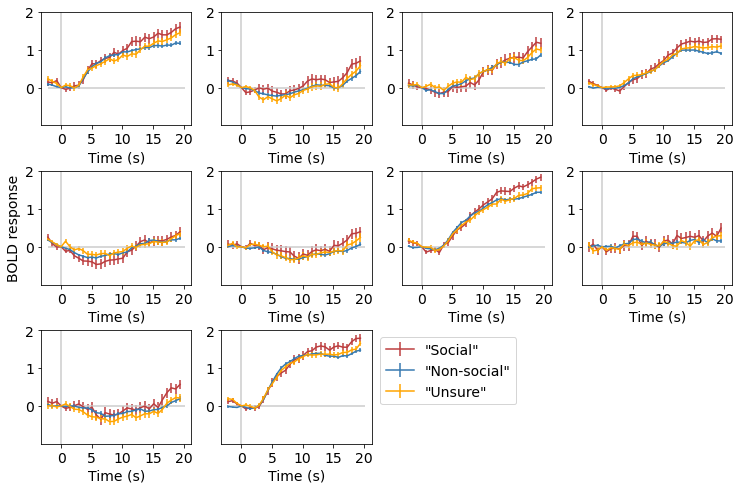

In [87]:
# plot timecourses of common nodes
if movie_rfx==1:
     nodes_to_plot = np.where(nodes_all_SUNS_UNSNS_ALL)[0]
else:
     nodes_to_plot = nodes_ind10

[ymin,ymax] = [-1,2]
xlbls = [0,5,10,15,20]
x_ticks = [(i/TR)+tr0_ind for i in xlbls]
xlbls = [str(i) for i in xlbls]
ncols = 4
nrows = int(np.ceil(nodes_to_plot.shape[0]/ncols))
if movie_rfx == 1:
     fig,ax =plt.subplots(nrows = nrows, ncols = ncols, sharex=False, 
     sharey=False, figsize = (12,4)) # figsize = (20,15))
else:
     fig,ax =plt.subplots(nrows = nrows, ncols = ncols, sharex=False, 
     sharey=False, figsize = (12,6)) # figsize = (20,15))

for i,n in enumerate(nodes_to_plot): 
     if ncols == 1:
          ax1 = ax[i]
     else:
          r = int(np.floor(i/ncols))
          c = int(i % ncols)
          ax1 = ax[r,c]

     movieTC_yes = tcs_run_z[responses[:,4]==1,n,:,4] # nsubs * ntimepts
     movieTC_no  = tcs_run_z[responses[:,4]==0,n,:,4] # nsubs * ntimepts
     movieTC_unsure  = tcs_run_z[responses[:,4]==9,n,:,4] # nsubs * ntimepts
     
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_yes,axis=0),stats.sem(movieTC_yes,axis=0,nan_policy='omit'),color = red_rgb,linewidth=1.5,label ='"Social"')
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_no,axis=0),stats.sem(movieTC_no,axis=0,nan_policy='omit'),color = blue_rgb,linewidth=1.5,label ='"Non-social"')
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_unsure,axis=0),stats.sem(movieTC_unsure,axis=0,nan_policy='omit'),color = 'orange',linewidth=1.5,label ='"Unsure"')
     ax1.vlines(tr0_ind,-1,2,color=[.8,.8,.8])
     ax1.hlines(0,0,31,color=[.8,.8,.8])
     ax1.set_ylim(ymin,ymax)
     ax1.set_xticks(x_ticks)
     ax1.set_xticklabels(xlbls, fontsize=14)
     ax1.set_yticks([0,1,2])
     ax1.set_yticklabels([i for i in [0,1,2]],fontsize=14)
     if  (c==0) & (r == int(nrows/2)):
          ax1.set_ylabel('BOLD response', fontsize=14 )
     ax1.set_xlabel('Time (s)', fontsize=14 )
     if i==len(nodes_to_plot)-1:#(r==0) and (c==ncols-1):
          ax1.legend(bbox_to_anchor = [2.01,1],fontsize=14)

     MNIz = eval(shen268_lbl[str(n+1)][0])['coords'][2]
     
if ncols > 1:
     for i in range(int(nrows*ncols-len(np.where(nodes_to_plot)[0]))):
          ax[r,c+1+i].axis('off')
plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=.8, 
                        top=1, 
                        wspace=0.2, 
                        hspace=.4)

plt.savefig(os.path.join(fig_save_loc,f'common_nodes/social_unsure_nonsocial/all_ROIs_tc{lme_suff}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 1.0
8 1.0
9 1.0


/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


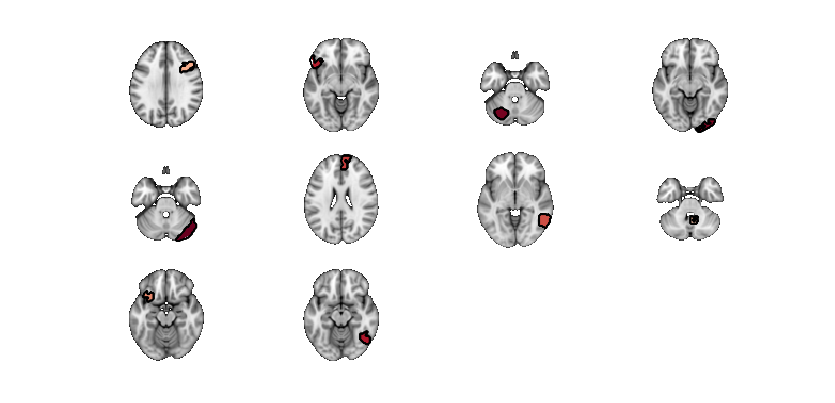

In [337]:
# save axial plots of each roi for visualization of each node next to plots above
# TAKES TIME, RUN ONLY IF NECESSARY!

start_time = time.time()
fig,axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12,6))
for i,n in enumerate(nodes_ind10): #for i,n in enumerate(df['Nodes']):
    print(i, np.round((time.time()-start_time)/60))
    #ax = fig.add_subplot(nrows,1,i+1)
    r = int(np.floor(i/ncols))
    c = int(i%ncols)
    ax = axs[r,c]
    
    nodes = np.zeros((268,))
    nodes[n] = meanDiff_sl_rand_S_UNS[n]

    img = roi_to_brain(pd.Series(nodes), mask_x)
    '''zsl = row[1]['MNIz']
    if np.abs(zsl-zslices[0]) < np.abs(zsl-zslices[1]):
        zsl = zslices[0]
    else:
        zsl = zslices[1]'''
    MNIz = eval(shen268_lbl[str(n+1)][0])['coords'][2]
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',cut_coords =[MNIz],cmap = 'RdBu_r',bg_img = bg_img,colorbar= False, threshold = .001,\
    vmin = -.26,vmax=.26,axes =ax,figure=fig,annotate=False) # cmap = 'plasma'
    ax_plot.add_contours(color_rois((nodes)),linewidths=1, colors=['k'],linestyles='solid')

if ncols > 1:
     for i in range(int(nrows*ncols-len(np.where(nodes_ind10)[0]))):
          axs[r,c+1+i].axis('off')
plt.tight_layout()

plt.savefig(os.path.join(fig_save_loc,f'common_nodes/social_unsure_nonsocial/all_ROIs{suff}.png'),dpi=300,bbox_inches='tight',facecolor='none', edgecolor='none')
